# WOFOST Approximate Bayesian Computation

This tutorial will cover the use of Approximate Bayesian Computation (ABC) on WOFOST for Bayesian calibration of computer simulation models.

Bayesian calibration of computer simulation models is a method to update uncertain model parameters using observed data and prior knowledge, producing a posterior distribution that reflects parameter uncertainty. It treats the simulator as a probabilistic function, often incorporating a discrepancy term to account for model–reality differences. This approach allows quantified predictions and uncertainty propagation in the model outputs. [A useful text on Bayesian calibration may be found here](https://rss.onlinelibrary.wiley.com/doi/abs/10.1111/1467-9868.00294). 

[A useful link covering Bayesian calibration for agent-based models may be found here.](https://www.sciencedirect.com/science/article/pii/S0304380015002173)

# Imports

We will first import all required dependencies.

In [35]:
import pandas as pd
import numpy as np
import yaml
import os.path as osp
import copy
from calisim.statistics import L2Norm

from calisim.data_model import (
	DistributionModel,
	ParameterDataType,
	ParameterSpecification,
)

from calisim.abc import (
	ApproximateBayesianComputationMethod,
	ApproximateBayesianComputationMethodModel,
)

import pcse
from pcse.models import Wofost72_PP
from pcse.base import ParameterProvider
from pcse.input import NASAPowerWeatherDataProvider, YAMLAgroManagementReader, YAMLCropDataProvider, WOFOST72SiteDataProvider, DummySoilDataProvider

# Observed data

We will next load the observed field data.

Climate data will be from the Netherlands (latitude=52, longitude=5).

We will set WAV (initial amount of available soil moisture in excess of the wilting point) to 50.

We will use dummy soil data.

In [36]:
wdp = NASAPowerWeatherDataProvider(latitude=52, longitude=5)
print(wdp)

Weather data provided by: NASAPowerWeatherDataProvider
--------Description---------
NASA/POWER Source Native Resolution Daily Data
----Site characteristics----
Elevation:    3.5
Latitude:  52.000
Longitude:  5.000
Data available for 1984-01-01 - 2025-10-21
Number of missing days: 0



In [37]:
sited = WOFOST72SiteDataProvider(WAV=50)
print(sited)

{'IFUNRN': 0, 'NOTINF': 0, 'SSI': 0.0, 'SSMAX': 0.0, 'WAV': 50.0, 'SMLIM': 0.4}


In [38]:
soild = DummySoilDataProvider()
print(soild)

{'SMFCF': 0.3, 'SM0': 0.4, 'SMW': 0.1, 'RDMSOL': 120, 'CRAIRC': 0.06, 'K0': 10.0, 'SOPE': 10.0, 'KSUB': 10.0}


In [39]:
cropd = YAMLCropDataProvider(fpath="data", force_reload=True)
print(cropd)

Crop parameters loaded from: /mnt/c/Users/james/projects/calisim-examples/workshop/6_wofost/data
Crop and variety not set: no active crop parameter set!



In [40]:
agro = YAMLAgroManagementReader(osp.join("data", "AGMT_C2_2020.agro"))
print(agro)

!!python/object/new:pcse.input.yaml_agro_loader.YAMLAgroManagementReader
listitems:
- 2020-04-20:
    CropCalendar:
      crop_end_date: 2020-11-03
      crop_end_type: maturity
      crop_name: potato
      crop_start_date: 2020-04-20
      crop_start_type: sowing
      max_duration: 300
      variety_name: Potato_C2_C5
    StateEvents: null
    TimedEvents: null



In [41]:
params = ParameterProvider(cropdata=cropd, sitedata=sited, soildata=soild)
wofost = Wofost72_PP(params, wdp, agro)
wofost.run_till_terminate()
observed_data = pd.DataFrame(wofost.get_output())
observed_data

,day,DVS,LAI,TAGP,TWSO,TWLV,TWST,TWRT,TRA,RD,SM,WWLOW
0,2020-04-20,-0.100000,0.120000,60.00000,0.000000,48.000000,12.000000,15.000000,0.000000,10.0,0.3,None
1,2020-04-21,-0.097173,0.120000,60.00000,0.000000,48.000000,12.000000,15.000000,0.000000,10.0,0.3,None
2,2020-04-22,-0.093882,0.120000,60.00000,0.000000,48.000000,12.000000,15.000000,0.000000,10.0,0.3,None
3,2020-04-23,-0.090047,0.120000,60.00000,0.000000,48.000000,12.000000,15.000000,0.000000,10.0,0.3,None
4,2020-04-24,-0.085667,0.120000,60.00000,0.000000,48.000000,12.000000,15.000000,0.000000,10.0,0.3,None
...,...,...,...,...,...,...,...,...,...,...,...,...
140,2020-09-07,1.963323,0.876336,16447.03535,11629.712391,3077.106707,1740.216253,1135.030442,0.128282,50.0,0.3,None
141,2020-09-08,1.972529,0.876336,16447.03535,11629.712391,3077.106707,1740.216253,1135.030442,0.088088,50.0,0.3,None
142,2020-09-09,1.982916,0.716347,16447.03535,11629.712391,3077.106707,1740.216253,1135.030442,0.085369,50.0,0.3,None
143,2020-09-10,1.992974,0.581502,16447.03535,11629.712391,3077.106707,1740.216253,1135.030442,0.071436,50.0,0.3,None


<Axes: xlabel='day', ylabel='LAI'>

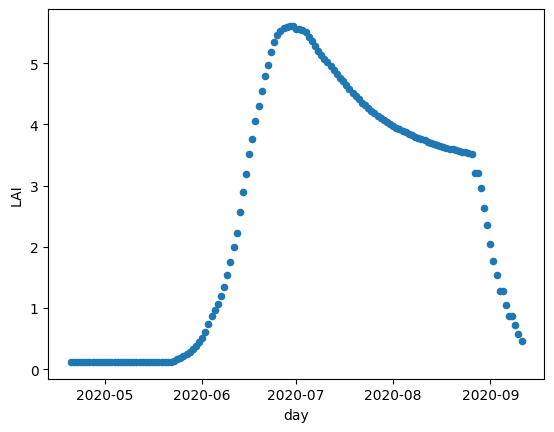

In [42]:
observed_data.plot.scatter("day", "LAI")

In [43]:
params.get("SPAN")

37.0

In [44]:
params.get("TDWI")

75.0

# Calibration procedure

## Bayesian calibration

[We will use Approximate Bayesian Computation (ABC) Sequential Monte Carlo to calibrate the model](https://academic.oup.com/book/54037/chapter-abstract/422208917?redirectedFrom=fulltext). ABC aims to minimise the discrepancy between observed and simulated data up to a tolerance threshold (epsilon). Larger values of epsilon will result in faster model calibration with fewer rejections of the forward model outputs but less precise estimates. Smaller values of epsilon will result in slower model calibration with more rejections of the forward model outputs but more precise estimates.

We will calibrate 2 parameters:

- SPAN: Life span of leaves growing at 35C
- TDWI: Initial total seed tuber dry weight

## Curse of dimensionality

ABC struggles with the curse of dimensionality with respect to the size of the simulation model outputs. 

When the observed data are high-dimensional, directly comparing simulated and observed datasets becomes increasingly unlikely to produce close matches, causing acceptance rates to plummet. To mitigate this, ABC relies on summary statistics that compress the data into lower-dimensional, informative representations. By focusing on key features rather than the full dataset, summary statistics reduce the effective dimensionality, making it feasible to identify parameter values that generate data consistent with observations. Without such dimensionality reduction, ABC can become computationally prohibitive and practically ineffective for large or complex outputs.

We will construct a vector of summary statistics for LAI.

In [45]:
observed_data.LAI.describe()

count    145.000000
mean       2.580539
std        2.001424
min        0.120000
25%        0.214734
50%        3.208223
75%        4.223383
max        5.609318
Name: LAI, dtype: float64

We first construct the parameter specification for Bayesian calibration. As we are going Bayesian, we can specify more complex probability distributions than the uniform distribution. In this example, we will use truncated normal distributions for our parameter specifications.

We specify both the location and scale, alongside the lower and upper bounds for the truncated normal distributions.

In [46]:
parameter_spec = ParameterSpecification(
	parameters=[
		DistributionModel(
			name="TDWI",
			distribution_name="truncnorm",
			distribution_args=[(20 - 75) / 10, (110 - 75) / 10],
            distribution_kwargs=dict(loc=75, scale=10),
			data_type=ParameterDataType.CONTINUOUS,
		),
		DistributionModel(
			name="SPAN",
			distribution_name="truncnorm",
			distribution_args=[(0 - 37) / 5, (60 - 37) / 5],
            distribution_kwargs=dict(loc=37, scale=5),
			data_type=ParameterDataType.CONTINUOUS,
		),
	]
)

Rather than using a metric such as mean squared error, ABC instead requires the use of proper distance metrics. Hence, we will use the L2 norm to quantify the discrepancy between the observed and simulated data.

In [47]:
def abc_func(
	parameters: dict, simulation_id: str, observed_data: np.ndarray | None
) -> float | list[float]:
    p = copy.deepcopy(params)
    for k in parameters:
        p.set_override(k, parameters[k])
                
    wofost = Wofost72_PP(p, wdp, agro)
    wofost.run_till_terminate()
    simulated_data = pd.DataFrame(wofost.get_output()).LAI.describe().values
    
    metric = L2Norm()
    discrepancy = metric.calculate(observed_data, simulated_data)
    return discrepancy

[We will use Approximate Bayesian Computation (ABC) Sequential Monte Carlo to calibrate the model](https://academic.oup.com/book/54037/chapter-abstract/422208917?redirectedFrom=fulltext). ABC aims to minimise the discrepancy between observed and simulated data up to a tolerance threshold (epsilon). Larger values of epsilon will result in faster model calibration with fewer rejections of the forward model outputs but less precise estimates. Smaller values of epsilon will result in slower model calibration with more rejections of the forward model outputs but more precise estimates.

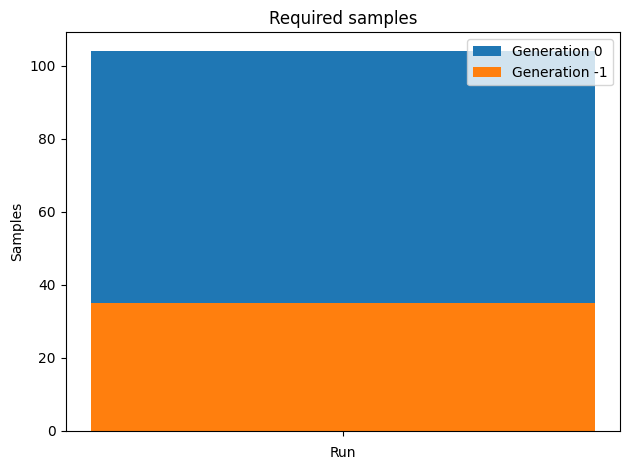

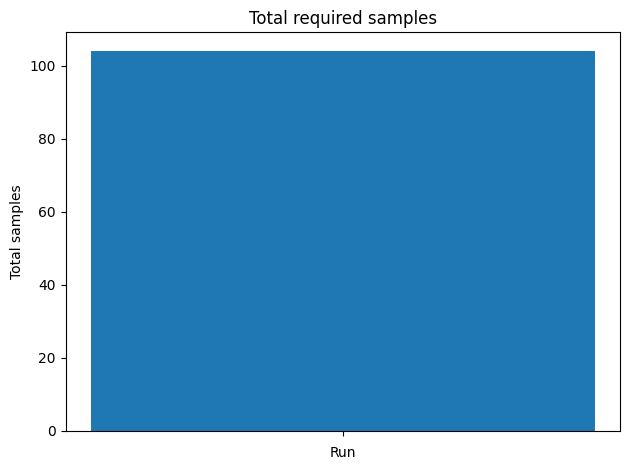

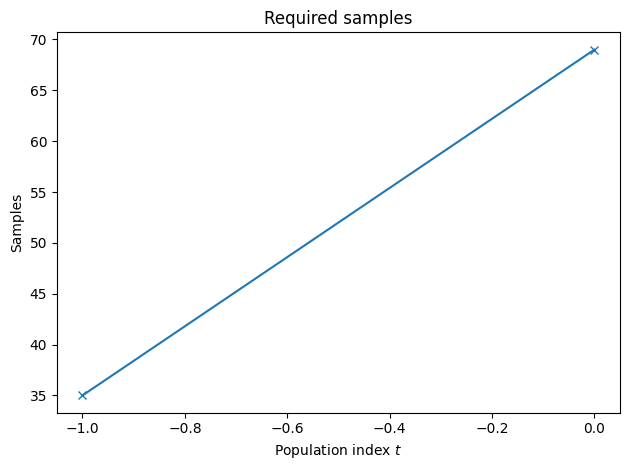

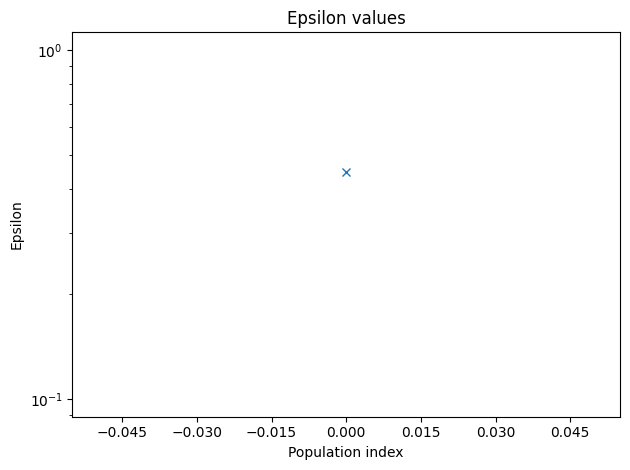

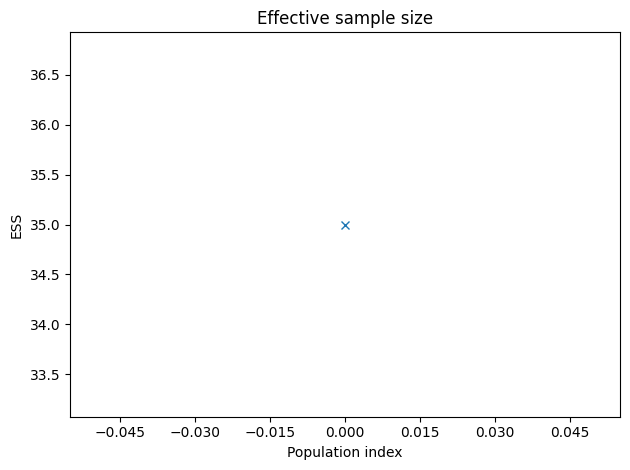

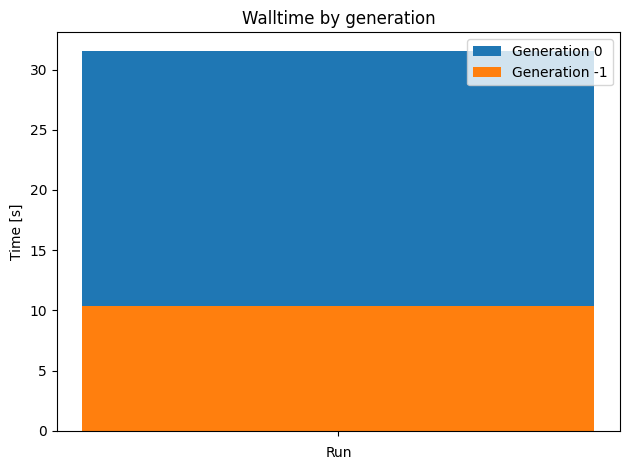

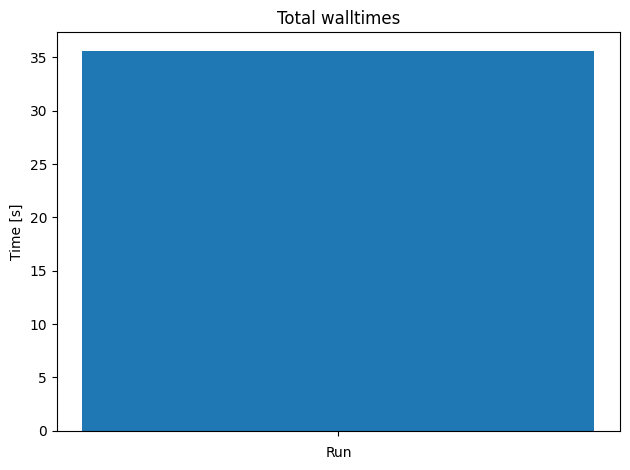

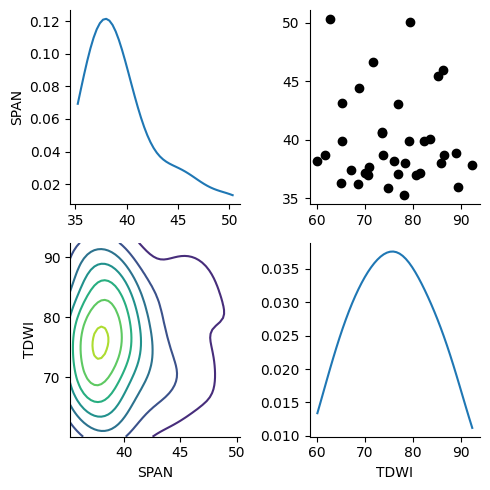

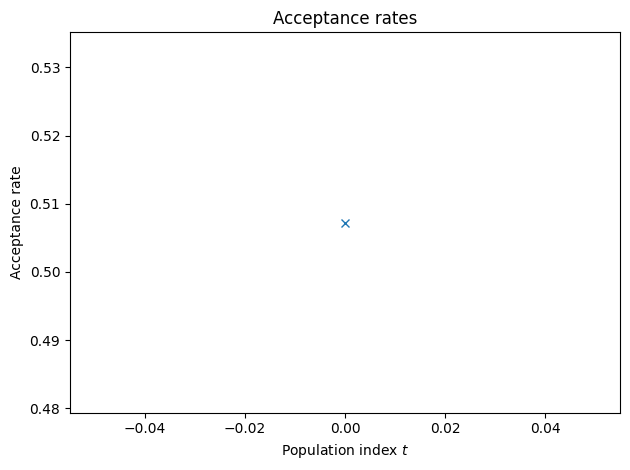

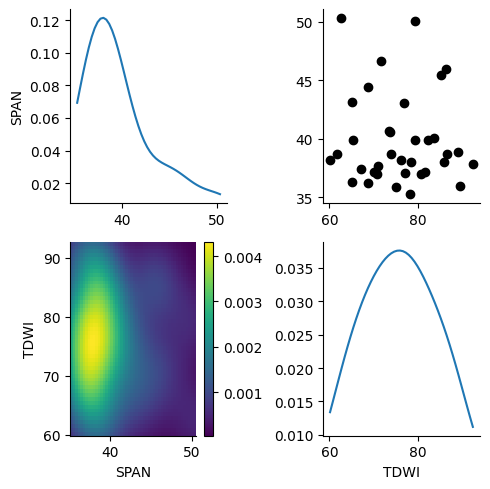

In [51]:
specification = ApproximateBayesianComputationMethodModel(
	experiment_name="pyabc_approximate_bayesian_computation",
	parameter_spec=parameter_spec,
	observed_data=observed_data.LAI.describe().values,
	n_init=35,
	walltime=5,  # minutes
	epsilon=10,
    output_labels=["Leaf Area Index Discrepancy"],
	n_bootstrap=35,
	min_population_size=35,
	verbose=True,
	batched=False,
    random_seed=100,
	method_kwargs=dict(
		max_total_nr_simulations=250, max_nr_populations=50, min_acceptance_rate=0.0
	),
)

calibrator = ApproximateBayesianComputationMethod(
	calibration_func=abc_func, specification=specification, engine="pyabc"
)

calibrator.specify().execute().analyze()

In [52]:
abc_df = pd.DataFrame({
    "parameter_name": [ 
        model.name
        for model in calibrator.get_parameter_estimates().estimates
    ],
    "parameter_estimate": [ 
        model.estimate
        for model in calibrator.get_parameter_estimates().estimates
    ],
    "parameter_uncertainty": [ 
        model.uncertainty
        for model in calibrator.get_parameter_estimates().estimates
    ],
})
abc_df

,parameter_name,parameter_estimate,parameter_uncertainty
0,SPAN,39.849531,3.913286
1,TDWI,75.788159,8.569468


We can see that Bayesian calibration provides a measure of uncertainty around the parameter estimates (the posterior mean and standard deviation). We can also refer to the ground truth values for the reference simulation.

```python
SPAN=37.0
TDWI=75.0
```

An exercise for the interested reader would be experiment with the number of samples taken by our ABC algorithm and also try changing our parameter specification, Currently, the bounds are very tight...you could say we're "cheating" a bit.